# **AI4BH Lab Session 1**

## **Problem:**

Prediction of type 2 diabetes mellitus (T2DM) at an early stage can lead to improved treatment and increased quality of life. Diagnosis of diabetes is considered a challenging problem at an early stage. A single parameter is not very effective at accurately diagnosing diabetes and may be misleading in the decision making process. There is a need to combine different parameters to effectively predict diabetes at an early stage. You need to develop a machine learning model that can predict whether people have diabetes based on a subset of their clinical data.


Read more:
https://www.nature.com/articles/s41598-020-61123-x


## **Dataset:**

The dataset is part of the large dataset held at the National Institutes of Diabetes-Digestive-Kidney Diseases (NIH). The target variable is specified as "Outcome"; 1 indicates positive diabetes test result, 0 indicates negative.

Dataset description can be found in this paper:
https://www.sciencedirect.com/science/article/pii/S2352914819300176


### **Variables:**
* Pregnancies    : Number of pregnancies
* Glucose        : 2-hour plasma glucose concentration in the oral glucose tolerance test
* Blood Pressure : Blood Pressure (mm Hg)
* Skin Thickness  : Skin Thickness
* Insulin        : 2-hour serum insulin (mu U/ml)
* Diabetes Pedigree Function
* BMI            : Body mass index
* Age            : Age (years)
* Outcome        : Have the disease (1) or not (0)

## 📚 0. Import Libraries (Nothing to do)

In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [89]:
# some adjustments
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

## 👓 1. Reading the Dataset (Nothing to do)

You can alternatively use colab's [import file feature](https://colab.research.google.com/notebooks/io.ipynb)

In [90]:
df_ = pd.read_csv('./biomed_diabetes.csv')
df = df_.copy()

In [91]:
# auxiliary functions
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def grab_col_names(dataframe, cat_th=10, car_th=20):
    """


    ------
        dataframe: dataframe

        cat_th: int, optional

        car_th: int, optinal


    Returns
    ------
        cat_cols: list
                Categorical features
        num_cols: list
                Numerical features
        cat_but_car: list
               Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car




def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

df.columns = [col.upper() for col in df.columns]

## 💿 2. Data preparation

In [92]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
PREGNANCIES                   int64
GLUCOSE                       int64
BLOODPRESSURE                 int64
SKINTHICKNESS                 int64
INSULIN                       int64
BMI                         float64
DIABETESPEDIGREEFUNCTION    float64
AGE                           int64
OUTCOME                       int64
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN    BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
##################### Tail #####################
     PREGNANCIE

In [93]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


### 2.1 Data exploration

❗**Plot the label distribution. What is the ratio of positive cases?**
(Hint: use the function cat_summary which uses seaborns  countplot: https://seaborn.pydata.org/generated/seaborn.countplot.html

Alternatively you can use the histplot method directly: https://seaborn.pydata.org/generated/seaborn.histplot.html.

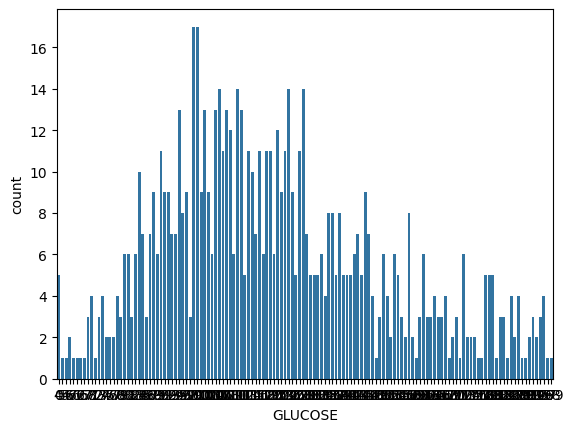

In [94]:
def cat_summary(dataframe, col_name, plot=False):
    # print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        # "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    # print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


## ... plot here ... ##

cat_summary(df, 'GLUCOSE', True)




❗**Summarize the features. Plot the distriobution of each feature. Do you notice anything weird?**

(Hint: use the histplot seaborn method: https://seaborn.pydata.org/generated/seaborn.histplot.html)

Tryout the pairplot method from seaborn also!

In [95]:

def num_summary(dataframe, numerical_col, plot= False):

    print(dataframe[numerical_col].describe().T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

# sns.pairplot(df)



❗**Are patients diagnosed with diabetes older or younger than the rest?** (You can use the function below. Or you  write your own script directly)

In [96]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [97]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

res = target_summary_with_num(df,'AGE', 'OUTCOME')

# print(df[df['OUTCOME'] == 1].agg)

# sns(res)

     OUTCOME
AGE         
21     0.079
22     0.153
23     0.184
24     0.174
25     0.292
26     0.242
27     0.250
28     0.286
29     0.448
30     0.286
31     0.542
32     0.562
33     0.588
34     0.286
35     0.500
36     0.625
37     0.316
38     0.625
39     0.250
40     0.462
41     0.591
42     0.389
43     0.846
44     0.625
45     0.533
46     0.538
47     0.667
48     0.200
49     0.600
50     0.625
51     0.625
52     0.875
53     0.800
54     0.667
55     0.250
56     0.667
57     0.200
58     0.429
59     0.667
60     0.400
61     0.500
62     0.500
63     0.000
64     0.000
65     0.000
66     0.500
67     0.333
68     0.000
69     0.000
70     1.000
72     0.000
81     0.000




❗**Plot the correlation matrix between different features (outcome included). Which feature is highest correlated with the target?** (Hint: Use the correlation function in the dataframe type. You can plot it using seaborn heatmap)

<Axes: >

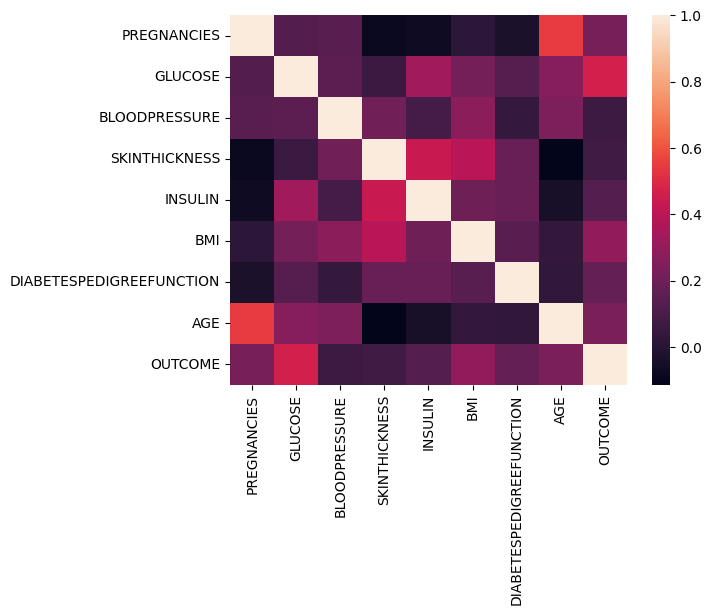

In [98]:
# f, ax = plt.subplots(figsize=[7, 5])
## ... add code here ##
sns.heatmap(df.corr())


# ax.set_title("Correlation Matrix", fontsize=20)
# plt.show()

### 2.2 Missing Value Analysis

❗**How many missing values (NA values) are there?** Hint: https://pandas.pydata.org/docs/user_guide/missing_data.html




In [99]:
## .. add code here ...

# df.count(df.isnull())
missing_counts = df.isna().sum()
print(missing_counts)


PREGNANCIES                 0
GLUCOSE                     0
BLOODPRESSURE               0
SKINTHICKNESS               0
INSULIN                     0
BMI                         0
DIABETESPEDIGREEFUNCTION    0
AGE                         0
OUTCOME                     0
dtype: int64


In [100]:
df[df==0].sum()

PREGNANCIES                0.000
GLUCOSE                    0.000
BLOODPRESSURE              0.000
SKINTHICKNESS              0.000
INSULIN                    0.000
BMI                        0.000
DIABETESPEDIGREEFUNCTION   0.000
AGE                        0.000
OUTCOME                    0.000
dtype: float64

However, if you look at BLOODPRESSURE (or BMI or INSULIN for example) you can notice some values which do not make any sense.  
How many nonsensical values are there?

In [101]:
## .. replace "??" by the nonsensical value .. ""
(df==0).sum()
# df.BLOODPRESSURE

PREGNANCIES                 111
GLUCOSE                       5
BLOODPRESSURE                35
SKINTHICKNESS               227
INSULIN                     374
BMI                          11
DIABETESPEDIGREEFUNCTION      0
AGE                           0
OUTCOME                     500
dtype: int64

❗ **Replace those values with NaN**

Hint: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html

(Here we replace the nonsensical values with NaN so that we can easily make use of pandas functions afterwards and test different data inputation methods. You can equally replace directly these values.)  

In [102]:
## .. replace only the relevant feature values .. ##
df[["GLUCOSE","BLOODPRESSURE","SKINTHICKNESS","INSULIN","BMI"]] = df[["GLUCOSE","BLOODPRESSURE","SKINTHICKNESS","INSULIN","BMI"]].replace(0, np.NaN) ## add code here ##

In [107]:
(df==np.NaN).sum()


PREGNANCIES                 0
GLUCOSE                     0
BLOODPRESSURE               0
SKINTHICKNESS               0
INSULIN                     0
BMI                         0
DIABETESPEDIGREEFUNCTION    0
AGE                         0
OUTCOME                     0
dtype: int64

In [108]:
na_cols = missing_values_table(df, True)

               n_miss  ratio
INSULIN           374 48.700
SKINTHICKNESS     227 29.560
BLOODPRESSURE      35  4.560
BMI                11  1.430
GLUCOSE             5  0.650


❗**How would you handle missing data?** Hint: you can use the function bellow.
Alternatively, use the fillna method: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html.

Some examples:
https://towardsdatascience.com/8-methods-for-handling-missing-values-with-python-pandas-842544cdf891




In [105]:
def median_target(variable):
    temp = df[df[variable].notna()]
    temp = temp[[variable, 'OUTCOME']].groupby(['OUTCOME'])[[variable]].median().reset_index()
    return temp

In [106]:



columns = df.columns
columns = columns.drop("OUTCOME")

for col in columns:
    df.loc[(df['OUTCOME'] == 0) & (df[col].isna()), col] = 
    df.loc[(df['OUTCOME'] == 1) & (df[col].isna()), col] = ## ??? ##




SyntaxError: invalid syntax (3516810594.py, line 5)

### 2.3 Feature Standarzation

❗**Why do we need feature standardization?** (Hint: to implement use a Scaler object from python)

In [109]:
from sklearn.preprocessing import StandardScaler

# Assuming 'df' is your DataFrame and 'num_cols' is a list of numerical column names

# Choose a scaler (StandardScaler in this case)
scaler = StandardScaler()

# Fit and transform the numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

# Display the first few rows of the transformed DataFrame
print(df.head())


   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN    BMI  DIABETESPEDIGREEFUNCTION    AGE  OUTCOME
0        0.640    0.862         -0.033          0.559      NaN  0.165                     0.468  1.426        1
1       -0.845   -1.202         -0.518         -0.015      NaN -0.846                    -0.365 -0.191        0
2        1.234    2.009         -0.679            NaN      NaN -1.323                     0.604 -0.106        1
3       -0.845   -1.071         -0.518         -0.588   -0.519 -0.630                    -0.921 -1.042        0
4       -1.142    0.502         -2.619          0.559    0.105  1.538                     5.485 -0.020        1


## 🤖 3. Model training and evalation


### 3.1 Simple model

❗**Train a ML model!** Data is already split into train and test. First, try out a [logistic regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). What accuracy do you get?      

In [ ]:
y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

## ...import your linear classifier ##
model = ## ... ##
## ...train your model ##
y_pred = ## ... predict on test data ##

y_pred = model.predict(X_test)
accuracy_score(y_pred, y_test)






### 3.2 Evaluation metrics

❗**Plot the results. What other metrics than accuracy can you think of?** Hint: [ROC](https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python). What about precision-recall? Confusion m...?

In [ ]:
import sklearn.metrics as metrics
## Calculate the fpr and tpr for all thresholds of the classification ##

probs = model.predict_proba(X_test)
y_pred_proba = probs[:,1]

## ... plot a roc curve ##

## ... plot a another curve? ##


from sklearn.metrics import confusion_matrix
## Get the confusion matrix ##

## ... add code here ##



### 3.3 Compare different types of classifiers

❗Try an SVM or a Random Forest. Hint: Check out the [sklearn](https://scikit-learn.org/stable/supervised_learning.html) classifiers.

In [ ]:
y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
## ... add code here ##


**Robust evaluation**

❗Evaluate your models performance on multiple train-test splits. What is the average performance of your models? Try out different metrics.  

Hint: [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html). You can either implement it on your own (for loop) or use the functions available in sklearn.

In [ ]:

#cross validation
## .. add code here ###

## 🗣️ 4. Discussion :

❗ **What is the problem you want to solve? Why is it important?**

❗ **Are there any challenges with the data?**

❗**What are the challenges of deploying this a model in a clinical setting? Would it work?**